# 1. Import Dependencies

In [1]:
# Import Dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import time

# 2. Model Definition Function

In [2]:
def init_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Valid', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Valid', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(519, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=["accuracy"])

    annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=2, factor=0.5, min_lr=0.0000001)

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

    return model, annealer, datagen

# 3. Load and Prepare Data

In [3]:
start_time = time.time()

# Load the data
train = pd.read_csv("/kaggle/input/digitrec/train.csv")
print(train.shape)

# Prepare dataset
y = train["label"]
X = train.drop("label", axis=1)
print(y.value_counts().to_dict())
y = to_categorical(y, num_classes=10)
del train

X = X / 255.0
X = X.values.reshape(-1, 28, 28, 1)

(42000, 785)
{1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795}


# 4. Split Data

In [4]:
# Shuffle Split Train and Test
seed = 2
train_index, valid_index = ShuffleSplit(n_splits=1,
                                       train_size=0.9,
                                       test_size=None,
                                       random_state=seed).split(X).__next__()
x_train = X[train_index]
Y_train = y[train_index]
x_test = X[valid_index]
Y_test = y[valid_index]

# Parameters
epochs = 30
batch_size = 64
validation_steps = 10000

# 5. Initialize and Train Model

In [5]:
# Initialize Model, Annealer and Datagen
model, annealer, datagen = init_model()

# Start training
train_generator = datagen.flow(x_train, Y_train, batch_size=batch_size)
test_generator = datagen.flow(x_test, Y_test, batch_size=batch_size)

history = model.fit(train_generator,
                   steps_per_epoch=x_train.shape[0]//batch_size,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=validation_steps//batch_size,
                   callbacks=[annealer])

score = model.evaluate(x_test, Y_test)
print('Test accuracy: ', score[1])

# Save model
model.save('Digits-1.3.0.h5')
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 64s 104ms/step - accuracy: 0.7279 - loss: 0.7887 - val_accuracy: 0.9707 - val_loss: 0.0997 - learning_rate: 0.0010
Epoch 2/30
  1/590 ━━━━━━━━━━━━━━━━━━━━ 57s 98ms/step - accuracy: 0.9531 - loss: 0.1962

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9531 - loss: 0.1962 - val_accuracy: 0.9688 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 3/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 58s 98ms/step - accuracy: 0.9653 - loss: 0.1153 - val_accuracy: 0.9790 - val_loss: 0.0678 - learning_rate: 5.0000e-04
Epoch 4/30
  1/590 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.9688 - loss: 0.1317
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9688 - loss: 0.1317 - val_accuracy: 0.9783 - val_loss: 0.0734 - learning_rate: 5.0000e-04
Epoch 5/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - accuracy: 0.9783 - loss: 0.0748 - val_accuracy: 0.9829 - val_loss: 0.0548 - learning_rate: 2.5000e-04
Epoch 6/30
  1/590 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.9844 - loss: 0.0600
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00012500000593

# 6. Plot History

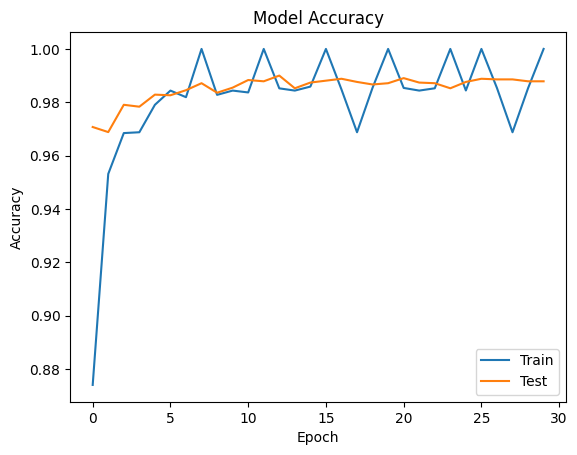

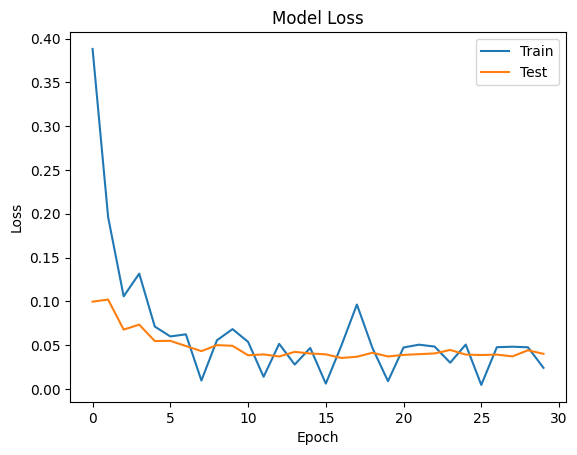

In [6]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 7. Make Predictions and Create Submission

In [8]:
# Make predictions on test set
test = pd.read_csv("/kaggle/input/digitrec/test.csv")
print(test.shape)
test = test / 255
test = test.values.reshape(-1, 28, 28, 1)
p = np.argmax(model.predict(test), axis=1)

# Print model scores
print('Base model scores:')
valid_loss, valid_acc = model.evaluate(x_test, Y_test, verbose=0)
valid_p = np.argmax(model.predict(x_test), axis=1)
target = np.argmax(Y_test, axis=1)
cm = confusion_matrix(target, valid_p)
print(cm)

# Create submission file
submission = pd.DataFrame(pd.Series(range(1, p.shape[0] + 1), name='ImageId'))
submission['Label'] = p
filename = f"keras-cnn-{str(int(score[1]*10000))}.csv"
submission.to_csv(filename, index=False)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

(28000, 784)
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step
Base model scores:
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
[[411   0   0   0   0   0   0   0   0   0]
 [  0 482   0   0   0   0   0   1   2   0]
 [  0   0 402   0   0   0   0   0   1   0]
 [  0   0   1 413   0   1   0   0   3   0]
 [  0   0   0   0 458   0   1   0   0   2]
 [  0   0   0   0   0 367   3   0   1   1]
 [  1   0   0   0   1   0 409   0   2   0]
 [  0   0   1   0   0   0   0 444   1   0]
 [  0   0   0   0   0   1   0   0 380   1]
 [  1   0   0   0   2   0   0   2   1 403]]
Elapsed time: 00:20:35
